<img src="../images/sample-nexrad-moore.png" width=600 alt="ARM Logo"></img>

# Looking at NEXRAD Data from Moore, Oklahoma
---

## Overview
   
Within this notebook, we will cover:

1. How to access NEXRAD data from AWS
1. How to read this data into Py-ART
1. How to customize your plots and maps

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Required | Projections and Features |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Required | Basic plotting |
| [Py-ART Basics](../foundations/pyart-basics) | Required | IO/Visualization |

- **Time to learn**: 45 minutes
---

## Imports

In [1]:
import pyart
import fsspec
from metpy.plots import USCOUNTIES
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## How to Access NEXRAD Data from Amazon Web Services (AWS)

Let’s start first with NEXRAD Level 2 data, which is ground-based radar data collected by the National Oceanic and Atmospheric Administration (NOAA), as a part of the National Weather Service (NWS) observing network.

### Level 2 Data
Level 2 data includes all of the fields in a single file - for example, a file may include:
- Reflectivity
- Velocity

### Search for Data from the Moore, Oklahoma Tornado (May 20, 2013)

Data We will access data from the **`noaa-nexrad-level2 bucket`**, with the data organized as:

```
s3://noaa-nexrad-level2/year/month/date/radarsite/{radarsite}{year}{month}{date}_{hour}{minute}{second}_V06
```

We can use [fsspec](https://filesystem-spec.readthedocs.io/en/latest/), a tool to work with filesystems in Python, to search through the bucket to find our files!

We start first by setting up our [AWS S3 filesystem](https://aws.amazon.com/s3/)

In [2]:
fs = fsspec.filesystem("s3", anon=True)

Once we setup our filesystem, we can list files from May 20, 2013 from the NWS Oklahoma City, Oklahoma (KTLX) site, around 2000 UTC.

In [3]:
files = sorted(fs.glob("s3://noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_20*"))
files

['noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_200356_V06.gz',
 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_200811_V06.gz',
 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_201229_V06.gz',
 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_201643_V06.gz',
 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_202058_V06.gz',
 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_202511_V06.gz',
 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_202928_V06.gz',
 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_203346_V06.gz',
 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_203800_V06.gz',
 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_204215_V06.gz',
 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_204630_V06.gz',
 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_205045_V06.gz',
 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_205459_V06.gz',
 'noaa-nexrad-level2/2013/05/20/KTLX/KTLX20130520_205914_V06.gz']

We now have a list of files we can read in! 

## Read the Data into PyART

When reading into PyART, we can use the `pyart.io.read_nexrad_archive` or `pyart.io.read` module to read in our data.

In [4]:
radar = pyart.io.read_nexrad_archive(f's3://{files[3]}')

Notice how for the **NEXRAD Level 2** data, we have several fields available

In [5]:
list(radar.fields)

['cross_correlation_ratio',
 'reflectivity',
 'differential_reflectivity',
 'spectrum_width',
 'velocity',
 'differential_phase']

### Plot a quick-look of the dataset
Let's get a quicklook of the reflectivity and velocity fields

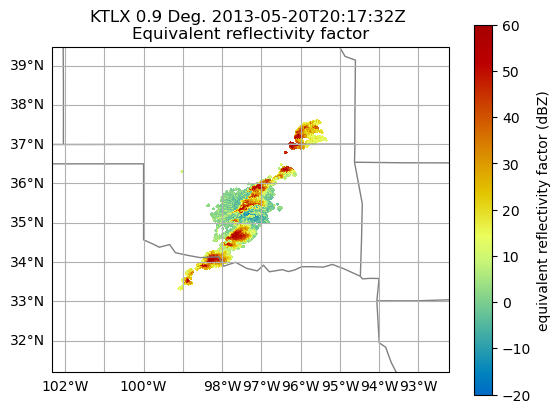

In [6]:
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity',
                     sweep=3,
                     vmin=-20,
                     vmax=60,
                     projection=ccrs.PlateCarree()
                    )

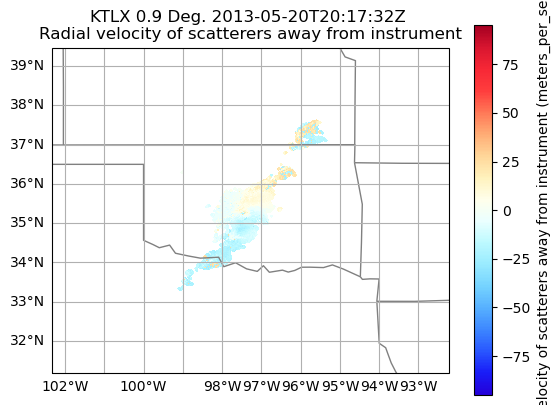

In [7]:
display.plot_ppi_map('velocity',
                     sweep=3,
                     projection=ccrs.PlateCarree(),
                    )

## How to customize your plots and maps
Let's add some more features to our map, and zoom in on our main storm

### Combine into a single figure
Let's start first by combining into a single figure, and zooming in a bit on our main domain.

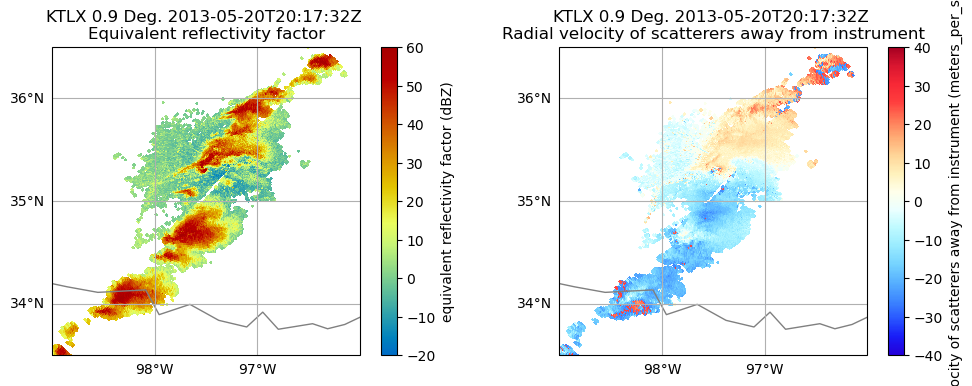

In [8]:
# Create our figure
fig = plt.figure(figsize=[12, 4])

# Setup our first axis with reflectivity
ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity',
                     sweep=3,
                     vmin=-20,
                     vmax=60,
                     ax=ax1,)

# Zoom in by setting the xlim/ylim
plt.xlim(-99, -96)
plt.ylim(33.5, 36.5)

# Setup our second axis for velocity
ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
display.plot_ppi_map('velocity',
                     sweep=3,
                     vmin=-40,
                     vmax=40,
                     projection=ccrs.PlateCarree(),
                     ax=ax2,)

# Zoom in by setting the xlim/ylim
plt.xlim(-99, -96)
plt.ylim(33.5, 36.5)
plt.show()

### Add Counties
We can add counties onto our map by using the `USCOUNTIES` module from `metpy.plots`

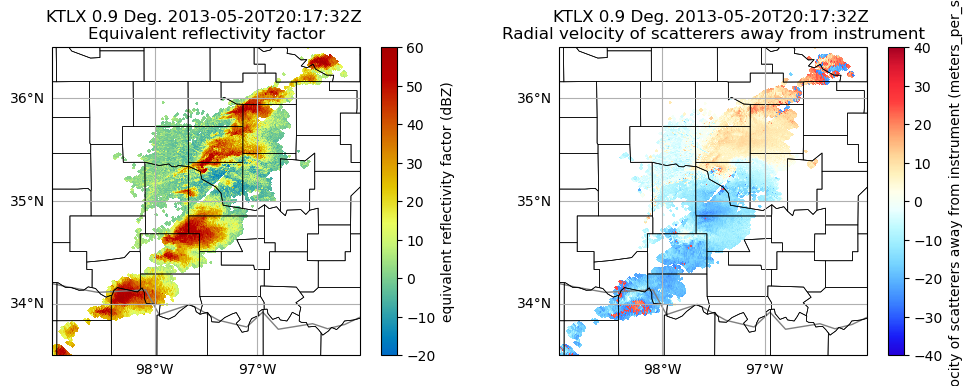

In [9]:
# Create our figure
fig = plt.figure(figsize=[12, 4])

# Setup our first axis with reflectivity
ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity',
                     sweep=3,
                     vmin=-20,
                     vmax=60,
                     ax=ax1,)

# Zoom in by setting the xlim/ylim
plt.xlim(-99, -96)
plt.ylim(33.5, 36.5)

# Add counties
ax1.add_feature(USCOUNTIES,
                linewidth=0.5)

# Setup our second axis for velocity
ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
display.plot_ppi_map('velocity',
                     sweep=3,
                     vmin=-40,
                     vmax=40,
                     projection=ccrs.PlateCarree(),
                     ax=ax2,)

# Zoom in by setting the xlim/ylim
plt.xlim(-99, -96)
plt.ylim(33.5, 36.5)

# Add counties
ax2.add_feature(USCOUNTIES,
                linewidth=0.5)

plt.show()

### Zoom in even more
Let's zoom in even more to our main feature - it looks like there is velocity couplet (where high positive and negative values of velcocity are close to one another, indicating rotation), near the center of our map.

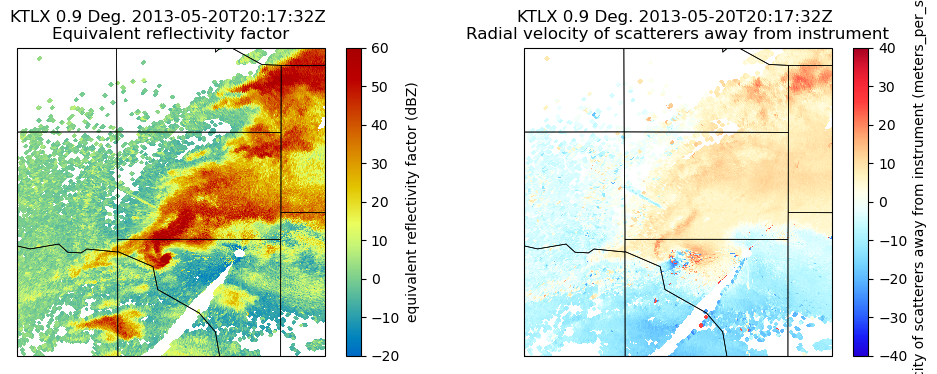

In [10]:
# Create our figure
fig = plt.figure(figsize=[12, 4])

# Setup our first axis with reflectivity
ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity',
                     sweep=3,
                     vmin=-20,
                     vmax=60,
                     ax=ax1,)

# Zoom in by setting the xlim/ylim
plt.xlim(-98, -97)
plt.ylim(35, 36)

# Add counties
ax1.add_feature(USCOUNTIES,
                linewidth=0.5)

# Setup our second axis for velocity
ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
display.plot_ppi_map('velocity',
                     sweep=3,
                     vmin=-40,
                     vmax=40,
                     projection=ccrs.PlateCarree(),
                     ax=ax2,)

# Zoom in by setting the xlim/ylim
plt.xlim(-98, -97)
plt.ylim(35, 36)

# Add counties
ax2.add_feature(USCOUNTIES,
                linewidth=0.5)

plt.show()

### Customize our Labels and Add Finer Grid Labels
You'll notice, by default, our colorbar label for the velocity field on the right extends across our entire figure, and the latitude/longitude labels on our axes are now gone. Let's fix that!

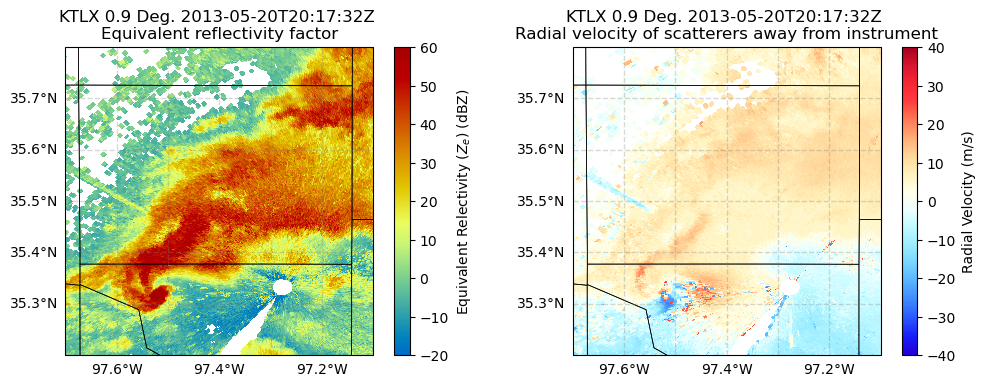

In [11]:
# Create our figure
fig = plt.figure(figsize=[12, 4])

# Setup our first axis with reflectivity
ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
ref_map = display.plot_ppi_map('reflectivity',
                               sweep=3,
                               vmin=-20,
                               vmax=60,
                               ax=ax1,
                               colorbar_label='Equivalent Relectivity ($Z_{e}$) (dBZ)')


# Zoom in by setting the xlim/ylim
plt.xlim(-97.7, -97.1)
plt.ylim(35.2, 35.8)

# Add gridlines
gl = ax1.gridlines(crs=ccrs.PlateCarree(),
                  draw_labels=True,
                  linewidth=1, 
                  color='gray', 
                  alpha=0.3,
                  linestyle='--')

# Make sure labels are only plotted on the left and bottom
gl.xlabels_top = False
gl.ylabels_right = False

# Increase the fontsize of our gridline labels
gl.xlabel_style = {'fontsize':10}
gl.ylabel_style = {'fontsize':10}

# Add counties
ax1.add_feature(USCOUNTIES,
                linewidth=0.5)

# Setup our second axis for velocity
ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
vel_plot = display.plot_ppi_map('velocity',
                                sweep=3,
                                vmin=-40,
                                vmax=40,
                                projection=ccrs.PlateCarree(),
                                ax=ax2,
                                colorbar_label='Radial Velocity (m/s)')

# Zoom in by setting the xlim/ylim
plt.xlim(-97.7, -97.1)
plt.ylim(35.2, 35.8)

# Add gridlines
gl = ax2.gridlines(crs=ccrs.PlateCarree(),
                   draw_labels=True,
                   linewidth=1, 
                   color='gray', 
                   alpha=0.3,
                   linestyle='--')

# Make sure labels are only plotted on the left and bottom
gl.xlabels_top = False
gl.ylabels_right = False

# Increase the fontsize of our gridline labels
gl.xlabel_style = {'fontsize':10}
gl.ylabel_style = {'fontsize':10}

# Add counties
ax2.add_feature(USCOUNTIES,
                linewidth=0.5)
plt.show()

---
## Summary
Within this example, we walked through how to use MetPy and PyART to read in NEXRAD Level 2 data from the Moore Oklahoma tornado in 2013, create some quick looks, and customize the plots to analyze the tornadic supercell closest to the radar.

### What's next?
Other examples will look at additional data sources and radar types, including data from the Department of Energy (DOE) Atmospheric Radiation Measurement (ARM) Facility, and work through more advanced workflows such as completing a dual-Doppler analysis.

## Resources and References
* [NEXRAD Data on AWS](https://registry.opendata.aws/noaa-nexrad/)
* [Py-ART NEXRAD Data Example](https://arm-doe.github.io/pyart/examples/io/plot_nexrad_data_aws.html#sphx-glr-examples-io-plot-nexrad-data-aws-py)